In [29]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

In [8]:
with open('input.txt', 'r') as f :
    data_in = f.read()
print(len(data_in))
data_in[:100]

1115394


'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [30]:
chrs = sorted(list(set(data_in)))
vocab_size = len(chrs)
print(vocab_size)
print(''.join(chrs))

65

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [10]:
stoi = {s:i for i,s in enumerate(chrs)}
itos = {i:s for s,i in stoi.items()}
encode = lambda s:[stoi[c] for c in s]
decode = lambda i:''.join([itos[x] for x in i])

print(encode('Hii There'))
print(decode(encode('Hii There')))

[20, 47, 47, 1, 32, 46, 43, 56, 43]
Hii There


In [14]:
data = encode(data_in)
print(data[:100])

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56, 58, 46, 43, 56, 6, 1, 46, 43, 39, 56, 1, 51, 43, 1, 57, 54, 43, 39, 49, 8, 0, 0, 13, 50, 50, 10, 0, 31, 54, 43, 39, 49, 6, 1, 57, 54, 43, 39, 49, 8, 0, 0, 18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 37, 53, 59]


In [17]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
print(len(train_data))
print(len(val_data))

1003854
111540


In [27]:
torch.manual_seed(1337)
block_size = 8
batch_size = 4
def get_batch(split) :
    data = torch.tensor(train_data if split=='train' else val_data)
    ix = torch.randint(len(data)-block_size, (batch_size,)) # getting random offsets
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print(xb.shape, xb, sep='\n')
print(yb.shape, yb, sep='\n')

torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


In [64]:
# making the simplest, Bigram model
torch.manual_seed(1337)
class Bigram(nn.Module) :
    def __init__(self, vocab_size) :
        super().__init__()
        self.emb = nn.Embedding(vocab_size, vocab_size)
    def forward(self, idx, targets=None) :
        logits = self.emb(idx) # outputs (B,T,C)
        B, T, C = logits.shape
        logits1 = logits.view(B*T, C)
        if targets!=None :
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits1, targets)
        else : loss=None
        return logits, loss
    def generate(self, idx, new_tokens) :
        # Takes in (B, T), outputs (B, T+new_tokens)
        for _ in range(new_tokens) :
            logits, loss = self(idx)
            logits = logits[:, -1, :] # focus on the last time step
            probs = F.softmax(logits, dim=-1)
            samples = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, samples], axis=1)
        return idx
    
model = Bigram(vocab_size)
out, loss = model(xb, yb)
print(out.shape, loss)

torch.Size([4, 8, 65]) tensor(4.8786, grad_fn=<NllLossBackward0>)


In [67]:
# Trying the untrained model with an initial input of zero
ix = torch.zeros((1,1), dtype=torch.long)
print(decode(model.generate(ix, new_tokens=100)[0].tolist()))


KuBZvrpxZQgC-hlkq,ptKqHoiX-jjeLJ &slERj KUsBOL!mpJO!zLg'wNfqHAMgq'hZCWhu.W.IBcP 
RFJ&DEs,nw?pxE?xjNH


In [75]:
batch_size = 32
lossi = []
optimiser = torch.optim.AdamW(model.parameters())
for _ in range(10000) : # epochs
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    lossi.append(loss.detach().item())
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

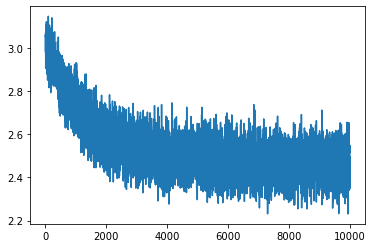

In [76]:
plt.plot(lossi)

In [77]:
# Trying the untrained model with an initial input of zero
ix = torch.zeros((1,1), dtype=torch.long)
print(decode(model.generate(ix, new_tokens=100)[0].tolist()))


Thisaru t IAREEroutersay.
AD:
Se m ane! ctcobsad, s IAle h mexK:
We, makisoung, hall-hithin p wate s


In [ ]:
# making the simplest, Bigram model
torch.manual_seed(1337)
vocab_size = len(chrs)
n_embed = 32
class Bigramv2(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.emb = nn.Embedding(vocab_size, n_embed)
        self.pos_emb = nn.Embedding(vocab_size, n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)
    def forward(self, idx, targets=None) :
        logits = self.emb(idx) # outputs (B,T,C)
        posemb = self.pos_emb(torch.arange(T)) # (T,C)
        logits = logits + posemb
        logits = self.lm_head(logits) # (B, T, vocab_size)
        B, T, C = logits.shape
        logits1 = logits.view(B*T, C)
        if targets!=None :
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits1, targets)
        else : loss=None
        return logits, loss
    def generate(self, idx, new_tokens) :
        # Takes in (B, T), outputs (B, T+new_tokens)
        for _ in range(new_tokens) :
            logits, loss = self(idx)
            logits = logits[:, -1, :] # focus on the last time step
            probs = F.softmax(logits, dim=-1)
            samples = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, samples], axis=1)
        return idx
    
model = Bigram(vocab_size)
out, loss = model(xb, yb)
print(out.shape, loss)

In [95]:
# implementing a single head of self attention
B,T,C = 4,8,32
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
x = torch.randn((B,T,C)) # input 

k = key(x) # (B, T, head_size)
q = query(x) # # (B, T, head_size)
wei = q @ k.transpose(-2,-1) ** head_size**-0.5 # (B, T, T)
# the scaling is used to control the variance of the output, since that is going to be passed through softmax

tril = torch.tril(torch.ones((T,T)))
wei_masked = wei.masked_fill(tril==0, float('-inf')) # B, T, T
wei_softed = F.softmax(wei_masked, dim=-1) # (B, T, T)

v = value(x)
out = wei_softed @ v # (B,T, T) @ (B, T, head_size) --> (B, T, head_size)


In [96]:
out.shape

torch.Size([4, 8, 16])

In [169]:
# creating the self attention class
n_embed = 32
head_size = 16
block_size = 8
torch.manual_seed(1337)
class Head(nn.Module) :
    def __init__(self, head_size) :
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones((block_size,block_size))))
    def forward(self, x) :
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(-2,-1) * x.shape[2]**-0.5
        wei_masked = wei.masked_fill(tril==0, float('-inf')) 
        wei_softed = F.softmax(wei_masked, dim=-1)
        out = wei_softed @ v
        return out
class MultiHeadAttention(nn.Module) :
    def __init__(self, num_heads, head_size) :
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    def forward(self, x) :
        return torch.cat([h(x) for h in self.heads], dim=-1)
    
class FeedForward(nn.Module) :
    def __init__(self, n_embed) :
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(n_embed, n_embed),
            nn.ReLU()
        )
    def forward(self, x) :
        return self.ff(x)

class Bigramv3(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.emb = nn.Embedding(vocab_size, n_embed)
        self.pos_emb = nn.Embedding(vocab_size, n_embed)
        self.sa_heads = MultiHeadAttention(4, n_embed//4)
        self.fwd = FeedForward(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)
    def forward(self, idx, targets=None) :
#         print(f'{targets=}')
        logits = self.emb(idx) # outputs (B,T,C)
        posemb = self.pos_emb(torch.arange(logits.shape[1])) # (T,C)
        logits = logits + posemb
        logits = self.sa_heads(logits)
        logits = self.fwd(logits)
        logits = self.lm_head(logits) # (B, T, vocab_size)
        B, T, C = logits.shape
        logits1 = logits.view(B*T, C)
        if targets!=None :
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits1, targets)
        else : loss=None
        return logits, loss
    def generate(self, idx, new_tokens) :
        # Takes in (B, T), outputs (B, T+new_tokens)
        for _ in range(new_tokens) :
            idx_cond = idx[:, -block_size:] # cropping, so that max length in dim=1 is blocksize
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # focus on the last time step
            probs = F.softmax(logits, dim=-1)
            samples = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, samples], axis=1)
        return idx
    

step=0 , loss : 4.159816741943359
step=500 , loss : 2.5311853885650635
step=1000 , loss : 2.3970253467559814
step=1500 , loss : 2.3273863792419434
step=2000 , loss : 2.408658504486084
step=2500 , loss : 2.4347546100616455
step=3000 , loss : 2.368178606033325
step=3500 , loss : 2.391223669052124
step=4000 , loss : 2.4107677936553955
step=4500 , loss : 2.3575146198272705


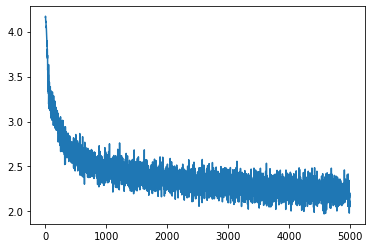

In [172]:
batch_size = 32
lossi = []

model = Bigramv3()
out, loss = model(xb, yb)

optimiser = torch.optim.AdamW(model.parameters())
for step in range(5000) : # epochs
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    lossi.append(loss.detach().item())
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    if step%500==0 :
        print(f'{step=} , loss : {lossi[-1]}')
plt.plot(lossi)

In [184]:
# Trying the untrained model with an initial input of zero
ix = torch.zeros((1,8), dtype=torch.long)
print(decode(model.generate(ix, new_tokens=100)[0].tolist())[8:])

GUKET:
Aithe thaply!

Iw kin tand this he aandos yeat incere,
Ther me heng Witelar.

Jich of sered t


In [193]:
# creating the self attention class
n_embed = 32
head_size = 16
block_size = 8
torch.manual_seed(1337)
class LayerNorm1d(nn.Module) :
    def __init__(self, dim, eps=1e-5, momentum=0.1) :
        super().__init__()
        self.eps = eps
        self.gamma = torch.ones(dim) # batch norm gain
        self.beta = torch.zeros(dim) # batch norm bias
        
    def __call__(self, x) :
        mean = x.mean(1, keepdims=True) # this is the only change from batchnorm
        var = x.var(1, keepdims=True)
        self.out = self.gamma*(x - mean) / torch.sqrt(var+self.eps) + self.beta
        
        return self.out
    def parameters(self) :
        return [self.gamma, self.beta]
    
class Head(nn.Module) :
    def __init__(self, head_size) :
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones((block_size,block_size))))
    def forward(self, x) :
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(-2,-1) * x.shape[2]**-0.5
        wei_masked = wei.masked_fill(tril==0, float('-inf')) 
        wei_softed = F.softmax(wei_masked, dim=-1)
        out = wei_softed @ v
        return out
class MultiHeadAttention(nn.Module) :
    def __init__(self, num_heads, head_size) :
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
    def forward(self, x) :
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.proj(out)

    
class FeedForward(nn.Module) :
    def __init__(self, n_embed) :
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(n_embed, 4*n_embed),
            nn.ReLU(),
            nn.Linear(4*n_embed, n_embed)
        )
    def forward(self, x) :
        return self.ff(x)

class Block(nn.Module) :
    def __init__(self, n_embed, n_head) :
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.fwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
        # seperate norm layers since params different
    def forward(self, x) :
        x = x + self.sa(self.ln1(x)) # adding residual connections, helps with grads
        x = x + self.fwd(self.ln2(x)) # adding layer normalisation as well, similar to batch norm
        return x

class Bigramv4(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.emb = nn.Embedding(vocab_size, n_embed)
        self.pos_emb = nn.Embedding(vocab_size, n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)
        
        self.blocks = nn.Sequential(
            Block(n_embed, 4),
            Block(n_embed, 4),
            Block(n_embed, 4),
            LayerNorm1d(n_embed)
        )
    def forward(self, idx, targets=None) :
#         print(f'{targets=}')
        logits = self.emb(idx) # outputs (B,T,C)
        posemb = self.pos_emb(torch.arange(logits.shape[1])) # (T,C)
        logits = logits + posemb
        logits = self.blocks(logits)
        logits = self.lm_head(logits) # (B, T, vocab_size)
        B, T, C = logits.shape
        logits1 = logits.view(B*T, C)
        if targets!=None :
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits1, targets)
        else : loss=None
        return logits, loss
    def generate(self, idx, new_tokens) :
        # Takes in (B, T), outputs (B, T+new_tokens)
        for _ in range(new_tokens) :
            idx_cond = idx[:, -block_size:] # cropping, so that max length in dim=1 is blocksize
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # focus on the last time step
            probs = F.softmax(logits, dim=-1)
            samples = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, samples], axis=1)
        return idx
    

step=0 , loss : 4.275749683380127
step=500 , loss : 1.5970845222473145
step=1000 , loss : 1.434525728225708
step=1500 , loss : 1.0263235569000244
step=2000 , loss : 0.8065274357795715
step=2500 , loss : 0.8270025849342346
step=3000 , loss : 0.743393063545227
step=3500 , loss : 0.5829977989196777
step=4000 , loss : 0.7124517560005188
step=4500 , loss : 0.5646693706512451


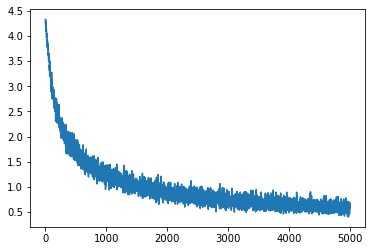

In [194]:
batch_size = 32
lossi = []

model = Bigramv4()
out, loss = model(xb, yb)

optimiser = torch.optim.AdamW(model.parameters())
for step in range(5000) : # epochs
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    lossi.append(loss.detach().item())
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    if step%500==0 :
        print(f'{step=} , loss : {lossi[-1]}')
plt.plot(lossi)